### Toymodel as an initial test
This is only a quick test to see if the model is applicable

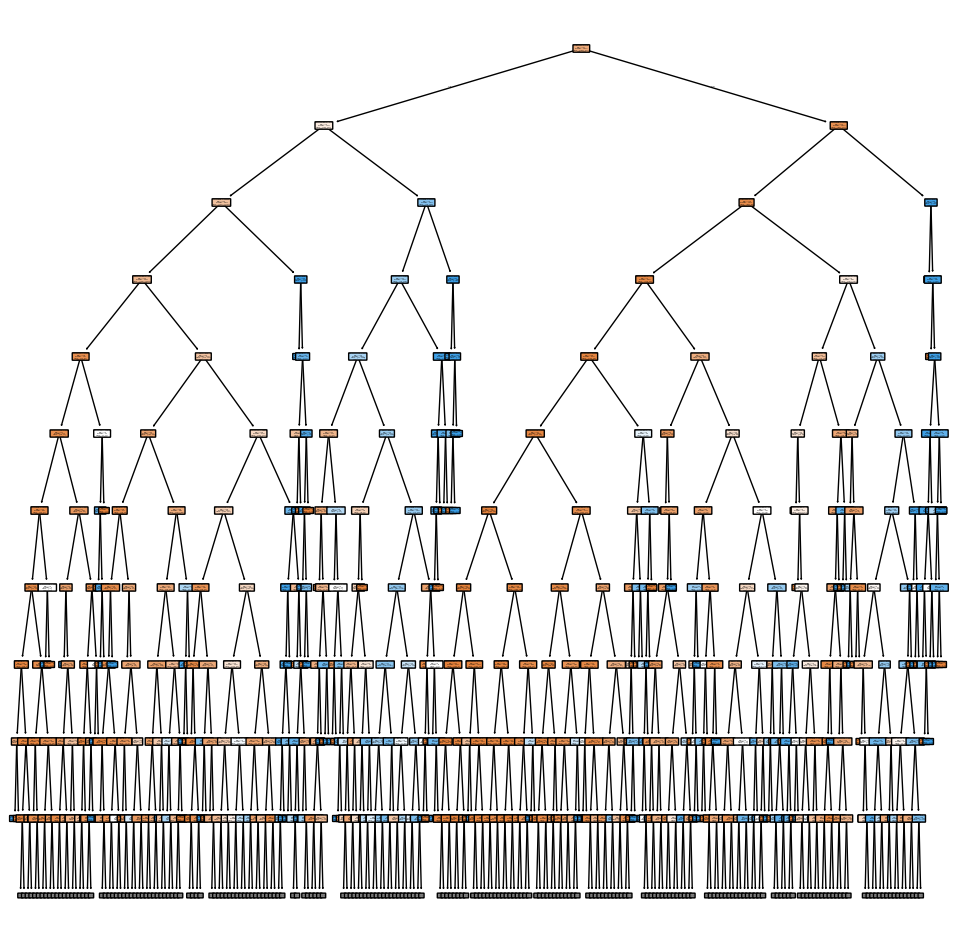

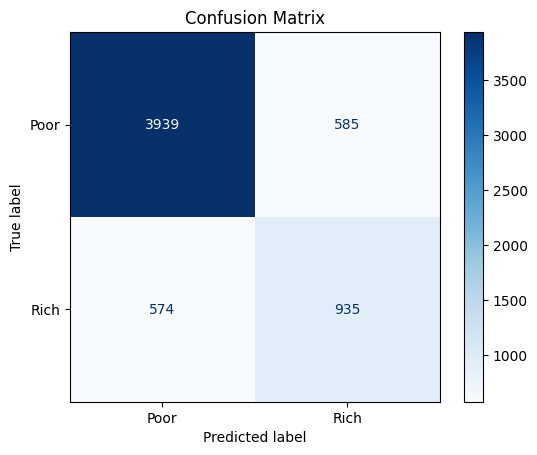

Classification Report:
              precision    recall  f1-score   support

        Poor       0.87      0.87      0.87      4524
        Rich       0.62      0.62      0.62      1509

    accuracy                           0.81      6033
   macro avg       0.74      0.75      0.74      6033
weighted avg       0.81      0.81      0.81      6033

Index(['age', 'workclass', 'education.num', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'native.country'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint

# Load dataset
df = pd.read_csv('./Datasets/adult.csv', comment = '#')

# First, create a copy of the dataframe to avoid modifying the original
df_encoded = df.copy()
df_encoded.drop(['fnlwgt', 'education'], axis=1, inplace=True)

# drop all rows that contain '?'
df_encoded = df_encoded[(df_encoded != '?').all(axis=1)]

# Apply label encoding to categorical columns
categorical_columns = ['workclass', 'marital.status', 'occupation', 
                      'relationship', 'race', 'sex', 'native.country', 'income']

for column in categorical_columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])

# Now properly separate features and target
X = df_encoded.drop(columns=['income'])
y = df_encoded['income']

# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


# Build pipeline
model = Pipeline([
    ('full_dt_classifier', DecisionTreeClassifier(random_state=42))  # Train Decision Tree Regressor
])

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Visualize the decision tree
plt.figure(figsize=(12, 12))
plot_tree(
    model.named_steps['full_dt_classifier'],
    feature_names=X.columns,
    class_names=["Poor", "Rich"],
    filled=True,
    rounded=True,
    max_depth=5,       # Keep tree shallow for readability
    fontsize=3,
    precision=2        # Limit decimals
)

plt.savefig('decision_tree.pdf', format='pdf', dpi=300)
plt.show()

CM = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["Poor", "Rich"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()  

print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Poor", "Rich"]))

print(X_train_val.columns)

### Hyperparameter tuning
I think this section is pretty unecessary. It can probably be removed, but I'm going to keep it for now, just in case. 

In [4]:
param_grid = {
                'full_dt_classifier__max_depth': [None, 10, 11, 12, 13, 14, 15, 16],
                'full_dt_classifier__min_samples_split': [3, 4, 5, 6, 7, 8, 9],
                'full_dt_classifier__min_samples_leaf': [1, 2, 3, 4, 5]
            }
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=skf, n_jobs=-1)
grid_search.fit(X_train, y_train)


# Best model training
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, y_pred_best, target_names=["Poor", "Rich"]))

best_max_depth = best_model.named_steps['full_dt_classifier'].max_depth
best_min_samples_split = best_model.named_steps['full_dt_classifier'].min_samples_split
best_min_samples_leaf = best_model.named_steps['full_dt_classifier'].min_samples_leaf

print(f'Best max_depth: {best_max_depth}')
print(f'Best min_samples_split: {best_min_samples_split}')
print(f'Best min_samples_leaf: {best_min_samples_leaf}')

KeyboardInterrupt: 

### Classifier comparison
This is taken from the ensemble lab. A lot of models are excluded, but they are easy to implement into the class, for now It's kept short to minimize the execution time. We can also tune more parameters for each model, but of course that would also increase the execution time.

In [3]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier        # Requires installation of the package ; Not a native function in sklearn
from lightgbm import LGBMClassifier      # Requires installation of the package; Not a native function in sklearn
from catboost import CatBoostClassifier  # Requires installation of the package; Not a native function in sklearn

class ClassifierComparisonOpt:
    def __init__(self, X, y, test_size=0.25, use_bootstrap=True, random_state=42, cv_folds=10):
        # Split data stratified by labels
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=random_state)

        # Scale features
        #scaler = StandardScaler()
        #self.X_train = scaler.fit_transform(X_train)
        #self.X_test  = scaler.transform(X_test)

        # Scaling not necessary for decision trees
        self.X_train = X_train
        self.X_test = X_test

        self.y_train       = y_train
        self.y_test        = y_test
        self.use_bootstrap = use_bootstrap
        self.cv_folds      = cv_folds
        self.models        = {}
        self.results       = {}
        self.results_df    = None
        self.feature_names = list(X.columns)

    def get_models_with_params(self):
        return {
            'Decision Tree': (DecisionTreeClassifier(random_state=42), {
                'max_depth': [None, 5, 10, 20],
                'min_samples_split': [2, 5, 10],
                #'min_samples_leaf': [2, 4, 6]
            }),
            'Random Forest': (RandomForestClassifier(bootstrap=self.use_bootstrap, random_state=42), {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 5, 10, 20],
                'min_samples_split': [2, 5, 10],
                #'min_samples_leaf': [2, 4, 6]
            }),
            'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                'max_depth': [3, 5, 10]
            })
        }

    def fit_models(self, models_with_params=None):
        # Set self.get_models_with_params() as a default parameter distribution
        if models_with_params == None:
            models_with_params = self.get_models_with_params()

        results_list = []
        cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=42)

        for name, (model, param_grid) in models_with_params.items():
            print(f"Tuning {name} ...")
            
            grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
            
            start_train = time.time()
            grid_search.fit(self.X_train, self.y_train)
            end_train = time.time()

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(self.X_test)
            end_pred = time.time()

            self.models[name] = {
                'model': best_model,
                'confusion_matrix': confusion_matrix(self.y_test, y_pred)
            }

            metrics = {
                'Model': name,
                'Accuracy': accuracy_score(self.y_test, y_pred),
                'Precision': precision_score(self.y_test, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(self.y_test, y_pred, average='weighted'),
                'F1 Score': f1_score(self.y_test, y_pred, average='weighted'),
                'Best Params': grid_search.best_params_,
                'Training Time (s)': (end_train - start_train),
                'Prediction Time (s)': (end_pred - end_train),
                'Total Time (s)': (end_pred - start_train)
            }

            results_list.append(metrics)

        self.results_df = pd.DataFrame(results_list)

    def print_summary(self):
        print("\n------ Results Sorted by Accuracy ------")
        print(self.results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))

        print("\n------ Results Sorted by Total Time ------")
        print(self.results_df.sort_values(by='Total Time (s)', ascending=True).to_string(index=False))

    # Show feature importance for models that support it          
    def show_feature_importance(self):
        importance = {}
        features = self.feature_names

        for name, result in self.models.items():
            model = result['model']
            if hasattr(model, 'feature_importances_'):
                importance[name] = model.feature_importances_
            elif hasattr(model, 'coef_'):
                coef = model.coef_
                if coef.ndim == 1:
                    importance[name] = np.abs(coef)
                else:
                    importance[name] = np.mean(np.abs(coef), axis=0)
            else:
                print(f"Feature importance not available for model {name}")

        for name, imp in importance.items():
            sorted_idx = np.argsort(imp)[::-1]
            sorted_features = [features[i] for i in sorted_idx]
            plt.figure()
            plt.bar(range(len(imp)), imp[sorted_idx], align='center')
            plt.xticks(range(len(imp)), sorted_features, rotation=70)
            plt.title(f"Feature importance for {name}")
            plt.xlabel("Feature index")
            plt.ylabel("Importance score")
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()


### Compare models with coarse hyperparameter tuning

In [8]:
# optimized classifiers and find their hyperparameters
clf_opt = ClassifierComparisonOpt(X_train_val, y_train_val)
clf_opt.fit_models()
clf_opt.print_summary()

Tuning Decision Tree ...
Tuning Random Forest ...
Tuning XGBoost ...

------ Results Sorted by Accuracy ------
        Model  Accuracy  Precision   Recall  F1 Score                                                     Best Params  Training Time (s)  Prediction Time (s)  Total Time (s)
      XGBoost  0.868059   0.863590 0.868059  0.863957     {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}          30.477441             0.007370       30.484811
Random Forest  0.858942   0.853479 0.858942  0.853443 {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}         109.089292             0.072799      109.162091
Decision Tree  0.848334   0.844900 0.848334  0.846228                       {'max_depth': 10, 'min_samples_split': 5}          10.185913             0.002266       10.188179

------ Results Sorted by Total Time ------
        Model  Accuracy  Precision   Recall  F1 Score                                                     Best Params  Training Time (s)  Prediction 

### Finetune and compare again
After tuning with a coarse grid we can use the result to select a finer grid and find better hyperparameters. This will only slightly improve the models, you will generally get diminishing returns the finer you tune.

In [5]:
# Define the classifiers and their hyperparameters in a finer grid
def get_fine_grids(use_bootstrap=True):
    return {
        'Decision Tree': (DecisionTreeClassifier(random_state=42), {
            'max_depth': [8, 10, 12],
            'min_samples_split': [4, 5, 6],
        }),
        'Random Forest': (RandomForestClassifier(bootstrap=use_bootstrap, random_state=42, n_jobs=-1), {
            'n_estimators': [75, 100, 150], 
            'max_depth': [15, 20, 25],
            'min_samples_split': [8, 10, 12],
        }),
        'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1), {
                'n_estimators': [75, 100, 150],
                'learning_rate': [0.15, 0.2, 0.25],
                'max_depth': [4, 5, 6]
            })
    }

# optimized classifiers and find their hyperparameters
#clf_opt = ClassifierComparisonOpt(X_train_val, y_train_val)
fine_grid = get_fine_grids()
#clf_opt.fit_models(fine_grid)
#clf_opt.print_summary()

# Show feature importance for each model
#clf_opt.show_feature_importance()

### Remove redundant features (optional)
If we want to remove redundant features, we will have to select different features for different models as the importance scores varied slightly between models. However, we have kept this section optional since we may want to use the same feature sets for all models in order to produce a fair comparison. Nevertheless, for optimal performance of each model, this step is advantageous.

In [4]:
# Remove redundant features for decision tree
X_dt = X_train_val.drop(columns=['sex', 'native.country', 'marital.status', 'race', 'occupation', 'workclass'])

# Remove redundant features for XGBoost
X_xgb = X_train_val.drop(columns=['native.country', 'race'])


# Train decision tree without redundant features
cmp_dt = ClassifierComparisonOpt(X_dt, y_train_val)
cmp_dt.fit_models({'Decision Tree': fine_grid['Decision Tree']})

# Train XGBoost without redundant features
cmp_xgb = ClassifierComparisonOpt(X_xgb, y_train_val)
cmp_xgb.fit_models({'XGBoost': fine_grid['XGBoost']})

# Train Random Forest, keep all features
cmp_rf = ClassifierComparisonOpt(X_train_val, y_train_val)
cmp_rf.fit_models({'Random Forest': fine_grid['Random Forest']})


# Print results
res = pd.concat([cmp_dt.results_df, cmp_rf.results_df, cmp_xgb.results_df])
print("\n------ Results Sorted by Accuracy ------")
print(res.sort_values(by='Accuracy', ascending=False).to_string(index=False))

NameError: name 'fine_grid' is not defined

### Final Models
I have not run this code yet. I'm still not sure if we should remove some of the features.

Classification Report:
              precision    recall  f1-score   support

        Poor       0.87      0.95      0.90      4533
        Rich       0.77      0.56      0.65      1500

    accuracy                           0.85      6033
   macro avg       0.82      0.75      0.78      6033
weighted avg       0.84      0.85      0.84      6033



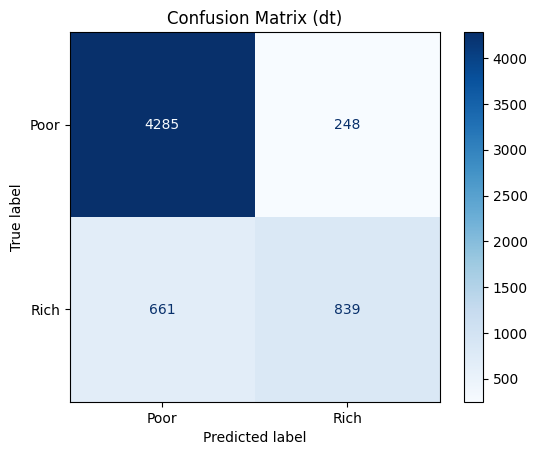

Classification Report:
              precision    recall  f1-score   support

        Poor       0.89      0.94      0.91      4533
        Rich       0.77      0.63      0.70      1500

    accuracy                           0.86      6033
   macro avg       0.83      0.79      0.80      6033
weighted avg       0.86      0.86      0.86      6033



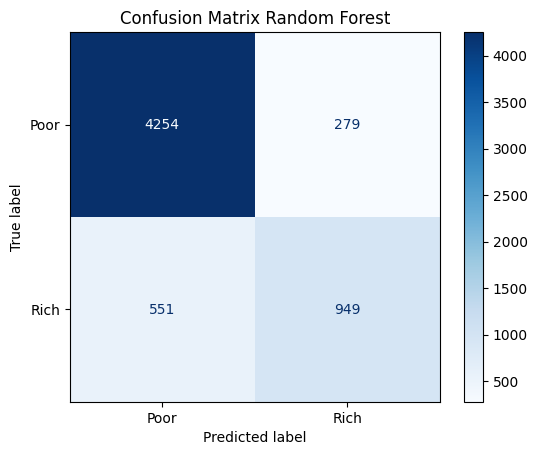

Classification Report:
              precision    recall  f1-score   support

        Poor       0.89      0.94      0.91      4533
        Rich       0.77      0.66      0.71      1500

    accuracy                           0.87      6033
   macro avg       0.83      0.80      0.81      6033
weighted avg       0.86      0.87      0.86      6033



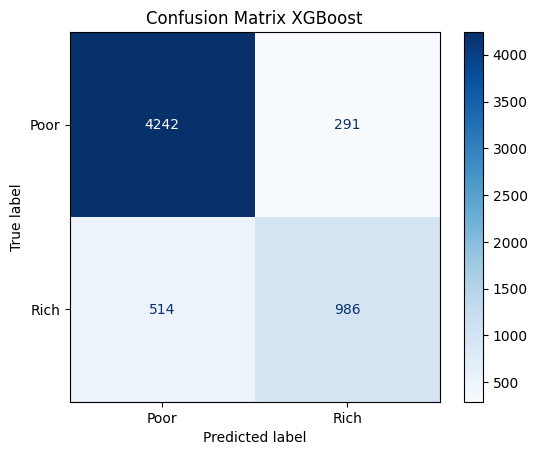

In [12]:
# ---------------------------- Decision Tree ----------------------------
dt = Pipeline([
    ('dt', DecisionTreeClassifier(max_depth=8, min_samples_split=4, random_state=42)) 
])

# Train the model
dt.fit(X_train_val, y_train_val)
y_pred_dt = dt.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=["Poor", "Rich"]))

CM = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["Poor", "Rich"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (dt)")
plt.savefig('./Report/CM_dt.png', format='png', dpi=300)
plt.show()  


# ---------------------------- Random Forest ----------------------------
rf = Pipeline([
    ('rf', RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=100, bootstrap=True, random_state=42))
])

# Train the model
rf.fit(X_train_val, y_train_val)
y_pred_rf = rf.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Poor", "Rich"]))

CM = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["Poor", "Rich"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix Random Forest")
plt.savefig('./Report/CM_rf.png', format='png', dpi=300)
plt.show() 


# ---------------------------- XGBoost ----------------------------
xgb = Pipeline([
    ('xgb', XGBClassifier(learning_rate=0.15, max_depth=5, n_estimators=100, random_state=42))
])

# Train the model
xgb.fit(X_train_val, y_train_val)
y_pred_xgb = xgb.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=["Poor", "Rich"]))

CM = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=["Poor", "Rich"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix XGBoost")
plt.savefig('./Report/CM_xgb.png', format='png', dpi=300)
plt.show() 